In [1]:
import collections
import sys
from pathlib import Path

import matplotlib.pyplot as plt
import matplotlib.transforms as mtrans
import matplotlib.patches as mpatches
import numpy as np
import pandas as pd
from skimage import exposure
from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar
import matplotlib.font_manager as fm
import cv2
fontprops = fm.FontProperties(size=34)
from sklearn.neighbors import NearestNeighbors
from skimage import color, measure, filters
import seaborn as sns
from matplotlib.colors import ListedColormap
import os
import skimage
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from skimage import filters
import matplotlib.gridspec as gridspec
from collections import defaultdict
from scipy.ndimage import distance_transform_edt
from matplotlib.patches import Rectangle
from collections import Counter
from skimage.filters.rank import median
from skimage.morphology import disk, ball

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
# Import path
module_path = str(Path.cwd().parents[0])
if module_path not in sys.path:
    sys.path.append(module_path)
    
module_path = str(Path.cwd().parents[0] / "src")
if module_path not in sys.path:
    sys.path.append(module_path)
    

In [4]:
from config import *
import my_io as io

# Import metadata information

In [5]:
df_metadata = pd.read_csv(data_dir / 'metadata.csv')
df_metadata.head()

Pos Grades Stage                                         Directory
0  B1      2     I  Y:\coskun-lab\Thomas\Lung IMC\data\ROI\ROI001_B1
1  B3      2     I  Y:\coskun-lab\Thomas\Lung IMC\data\ROI\ROI005_B3
2  B5      2    II  Y:\coskun-lab\Thomas\Lung IMC\data\ROI\ROI006_B5
3  C6     AT    AT  Y:\coskun-lab\Thomas\Lung IMC\data\ROI\ROI007_C6
4  D7      3  IIIA  Y:\coskun-lab\Thomas\Lung IMC\data\ROI\ROI008_D7

In [6]:
datasets = df_metadata.Directory.to_list()
datasets = [name.split('\\')[-1] for name in datasets]

In [7]:
print(datasets)

['ROI001_B1', 'ROI005_B3', 'ROI006_B5', 'ROI007_C6', 'ROI008_D7', 'ROI009_D9', 'ROI012_E1', 'ROI015_B6', 'ROI016_F3', 'ROI017_F2', 'ROI018_G1', 'ROI019_G5', 'ROI020_E5', 'ROI021_E7']


# Analysis

In [8]:
DEFAULT_CHANNELS = (1, 2, 3, 4)

RGB_MAP = {
    1: {
        'rgb': np.array([255, 0, 255]),
        'range': [0,255]
    },
    2: {
        'rgb': np.array([0,255,0]),
        'range': [0,255]
    },
    3: {
        'rgb': np.array([0, 0, 255]),
        'range': [0,255]
    },
    4: {
        'rgb': np.array([255, 204, 51]),
        'range': [0,255]
    }
}

def convert_to_rgb(t, channels=DEFAULT_CHANNELS, vmax=255, rgb_map=RGB_MAP):
    """
    Converts and returns the image data as RGB image
    Parameters
    ----------
    t : np.ndarray
        original image data
    channels : list of int
        channels to include
    vmax : int
        the max value used for scaling
    rgb_map : dict
        the color mapping for each channel
        See rxrx.io.RGB_MAP to see what the defaults are.
    Returns
    -------
    np.ndarray the image data of the site as RGB channels
    """
    dim1,dim2,_ = t.shape
    colored_channels = []
    for i, channel in enumerate(channels):
        x = (t[:, :, channel-1] / vmax) / \
            ((rgb_map[channel]['range'][1] - rgb_map[channel]['range'][0]) / 255) + \
            rgb_map[channel]['range'][0] / 255
        x = np.where(x > 1., 1., x)
        x_rgb = np.array(
            np.outer(x, rgb_map[channel]['rgb']).reshape(dim1,dim2, 3),
            dtype=int)
        colored_channels.append(x_rgb)
    im = np.array(np.array(colored_channels).sum(axis=0), dtype=int)
    im = np.where(im > 255, 255, im)
    im = im.astype(np.uint8)
    return im


def one_channel(t, channel, vmax=255, rgb_map=RGB_MAP):
    """
    Converts and returns the image data as RGB image
    Parameters
    ----------
    t : np.ndarray
        original image data
    channels : list of int
        channels to include
    vmax : int
        the max value used for scaling
    rgb_map : dict
        the color mapping for each channel
        See rxrx.io.RGB_MAP to see what the defaults are.
    Returns
    -------
    np.ndarray the image data of the site as RGB channels
    """
    dim1, dim2, _ = t.shape
    colored_channels = []
    x = (t[:, :, 0] / vmax) / (
        (rgb_map[channel]["range"][1] - rgb_map[channel]["range"][0]) / 255
    ) + rgb_map[channel]["range"][0] / 255
    x = np.where(x > 1.0, 1.0, x)
    x_rgb = np.array(
        np.outer(x, rgb_map[channel]["rgb"]).reshape(dim1, dim2, 3), dtype=int
    )
    colored_channels.append(x_rgb)
    im = np.array(np.array(colored_channels).sum(axis=0), dtype=int)
    im = np.where(im > 255, 255, im)
    im = im.astype(np.uint8)
    return im

In [9]:
from skimage.measure import block_reduce

def tile_array(a, b0, b1):
    r, c = a.shape                                    # number of rows/columns
    rs, cs = a.strides                                # row/column strides 
    x = as_strided(a, (r, b0, c, b1), (rs, 0, cs, 0)) # view a as larger 4D array
    return x.reshape(r*b0, c*b1)                      # create new 2D array

def mean_block(img, block_size):
    img_reduced = block_reduce(img, block_size=block_size, func=np.mean)
#     img_reduced = (img_reduced - img_reduced.min())/(img_reduced.max() - img_reduced.min())
    img_reduced /= 255
    return img_reduced

def myround(x, base=5):
    return base * round(x/base)

def plot_mean(imgs_list, n, path, labels):
    patch_matrix = []
    for c in range(4):
        patch_matrix.append(mean_block(imgs_list[c], (n,n)))

    fig, axs = plt.subplots(2,2, figsize = (12,10))
    ax = axs.flatten()
    norm = plt.Normalize(vmin=np.min(patch_matrix),
                         vmax=np.max(patch_matrix))
    for c, ax in enumerate(ax):
        ax.axis('off')
        im = ax.imshow(patch_matrix[c], cmap = 'RdYlBu_r', norm=norm)
        ax.title.set_text(labels[c])
    fig.subplots_adjust(hspace=0.1, wspace=0.01)
    cbar = fig.colorbar(im, ax=axs, shrink=0.5)
    cbar.set_label('Intensity')
    plt.show()
    fig.savefig(path, bbox_inches='tight')
    return patch_matrix

def plot_combined(imgs_list, n, path, int_min=0.05):
    patch_matrix = []
    for c in range(4):
        patch_matrix.append(mean_block(imgs_list[c], (n,n)))
    patch_matrix = np.array(patch_matrix)
    patch_max = np.argmax(patch_matrix, axis=(0))
    patch_max = np.where(np.all(patch_matrix < int_min, axis=0), np.nan, patch_max)
    
    rgb = np.array([[255,51,255], [51,255,51], [0,0,255], [255,204,51]])/255
#     rgb = np.array([[255,0,255], [0,255,0], [0,255,255], [255,255,0]])/255
    cmap = ListedColormap(rgb)
                   
    fig, ax = plt.subplots(figsize = (10,10))
    ax.imshow(patch_max, cmap=cmap, vmin=0, vmax=3, interpolation='none')
    ax.set_facecolor('black')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    fig.savefig(path, bbox_inches='tight')
    return patch_max

In [10]:
marker_list = [['Ki67', 'PanKeratin'], ['CD68'],['CD8a', 'CD3'], ['Col1', 'SMA']]
labels = ['Ki67+PanKeratin', 'CD68', 'CD8a+CD3', 'Col1+SMA']

# marker_list = [['Ki67', 'PanKeratin'], ['CD68','CD8a', 'CD3']]
# labels = ['Ki67+PanKeratin', 'CD68+CD8a+CD3']

marker_list = [['ECadherin','PanKeratin'], ['CD68'],['CD8a'], ['Col1', 'SMA']]
labels = ['ECA+PanK', 'CD68', 'CD8a', 'Col1+SMA']

In [11]:
def get_proportion(patch_max, n):
    img_size = patch_max.shape[0] * patch_max.shape[1]
    P = np.count_nonzero(patch_max == n) / img_size
    return P

def get_label_img(patch_max, n):
    labels = measure.label(patch_max == n, background=0, connectivity=2)
    return labels

def get_contour(labeled_img, n = 2):
    labels = np.unique(labeled_img)[1:]
    contours = []

    for label in labels:
        mask_label = (labeled_img == label)
        mask_label = ~mask_label
        distances = distance_transform_edt(mask_label)
        contour = np.where(np.logical_and(distances>=1, distances<n), 1, 0)
        row, col = np.where(contour > 0)
        contours.append(np.array(list(zip(row, col))))
        
    return labels, contours

def get_neighbor_env(img_labeled, patch_max, n_size=2, show=True):
    props = measure.regionprops(img_labeled)
    areas = []
    labels = []
    counts = []
    bboxs = []
    for prop in props:
        if prop['area'] > 1:
            bbox = np.asarray(prop['bbox'])
            bbox += np.array([-n_size, -n_size , n_size , n_size])
            bbox = np.clip(bbox, a_min = 0, a_max = None)
            row_min, col_min, row_max, col_max = bbox

            patch_max_roi = patch_max[row_min: row_max, col_min:col_max]
            size = patch_max_roi.size
            patch_max_roi = patch_max_roi[~np.isnan(patch_max_roi)].astype(int)
            count = Counter(patch_max_roi[~np.isnan(patch_max_roi)])   
            count = {k:v/size for k,v in count.items()}
            counts.append(count)
            areas.append(prop['area'])
            labels.append(prop['label'])
            bboxs.append(bbox)


    if show:
        rgb = np.array([[255,51,255], [51,255,51], [0,0,255], [255,204,51]])/255
        cmap = ListedColormap(rgb)
        fig, ax = plt.subplots( figsize=(10,10))
        ax.imshow(patch_max, cmap=cmap, vmin=0, vmax=3, interpolation='none')
        ax.set_facecolor('black')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        for bbox in bboxs:
            row_min, col_min, row_max, col_max = bbox
            ax.add_patch(Rectangle((col_min-1, row_min-1), col_max-col_min+1, row_max-row_min+1, fill=None, alpha=1, edgecolor='b', lw=2))
    return counts, areas, labels, bboxs

def get_contour_env(img_labeled, contours, patch_max, show=True):
    if show:
        mask = np.zeros(img_labeled.shape)*np.nan
        for contour in contours:
            mask[contour[:, 0], contour[:, 1]] = 1
        fig, ax = plt.subplots(figsize=(10,10))
        ax.imshow(mask, cmap='hsv')
        ax.imshow(np.where(img_labeled == 0, np.nan, 0), cmap='Pastel2')
        ax.axis('off')
    
    counts = []
    for contour in contours:
        env = patch_max[contour[:,0], contour[:,1]]
        size = len(env)
        count = Counter(env[~np.isnan(env)].astype(int))   
        count = {k:v/size for k,v in count.items()}
        counts.append(count)
        
    return counts

def get_interaction(counts):
    tumor_int = []
    stroma_int = []
    ip_int = []
    in_int = []

    for count in counts:
        tumor_int.append(count.get(0, 0.))
        in_int.append(count.get(1, 0.))
        ip_int.append(count.get(2, 0.))
        stroma_int.append(count.get(3, 0.))

    tumor_int = np.mean(tumor_int)
    stroma_int = np.mean(stroma_int)
    ip_int = np.mean(ip_int)
    in_int = np.mean(in_int)

    return tumor_int, stroma_int, ip_int, in_int



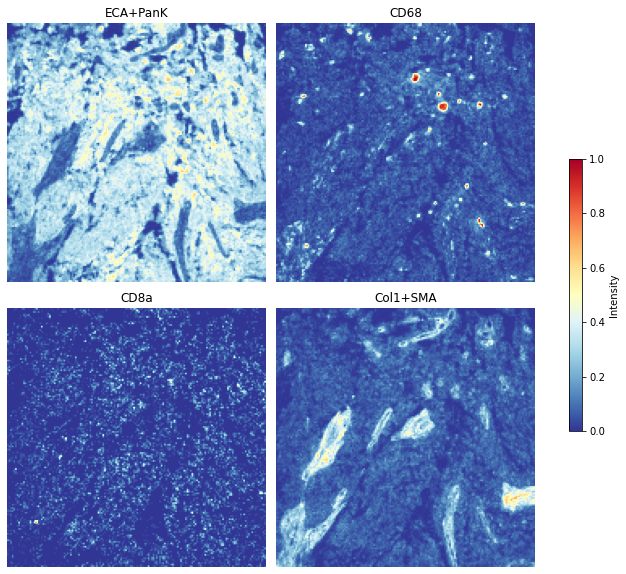

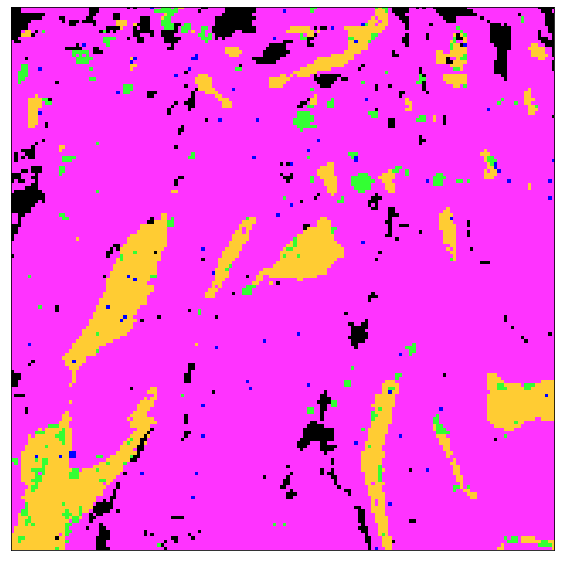

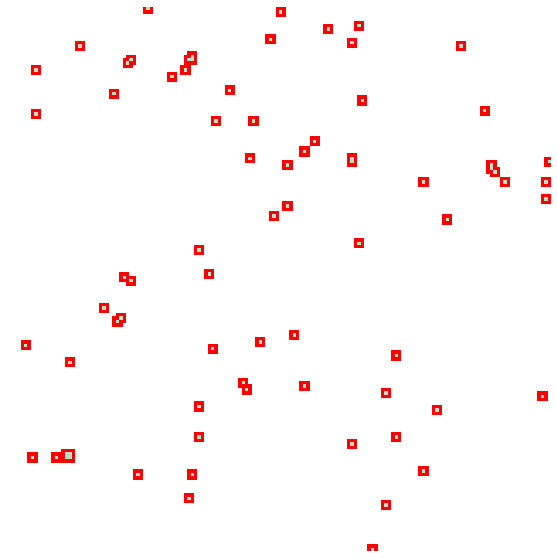

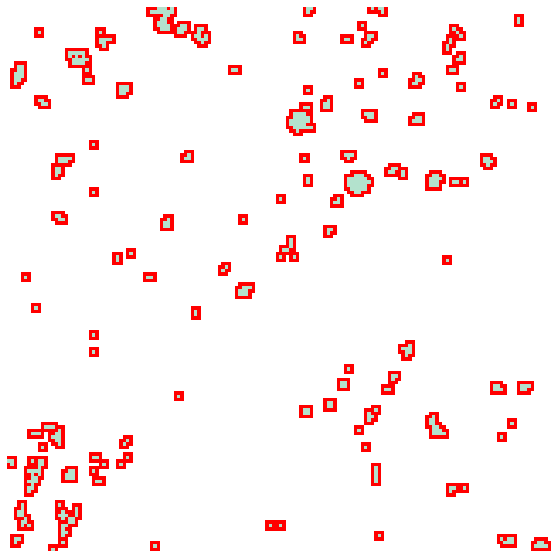

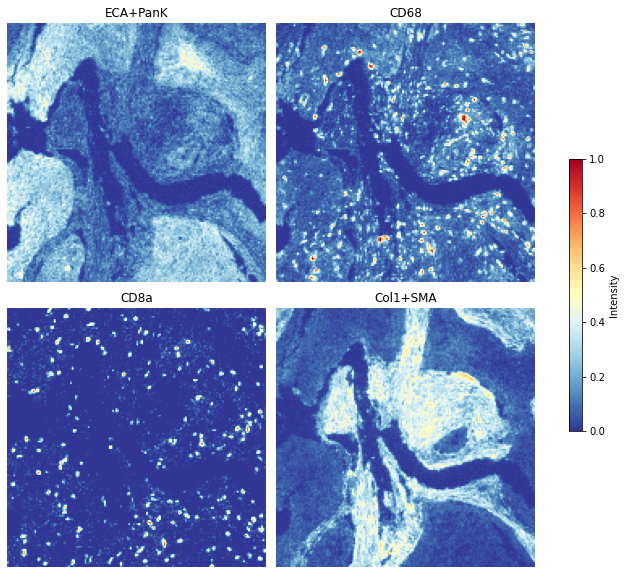

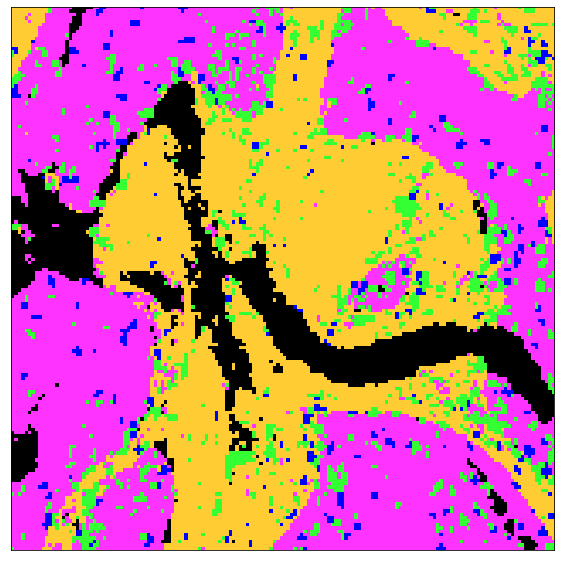

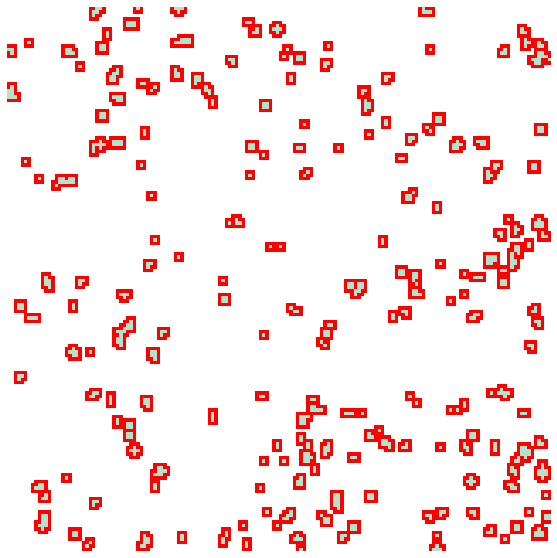

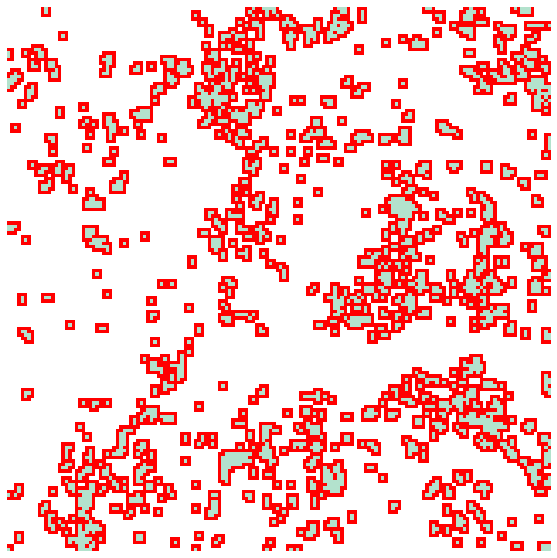

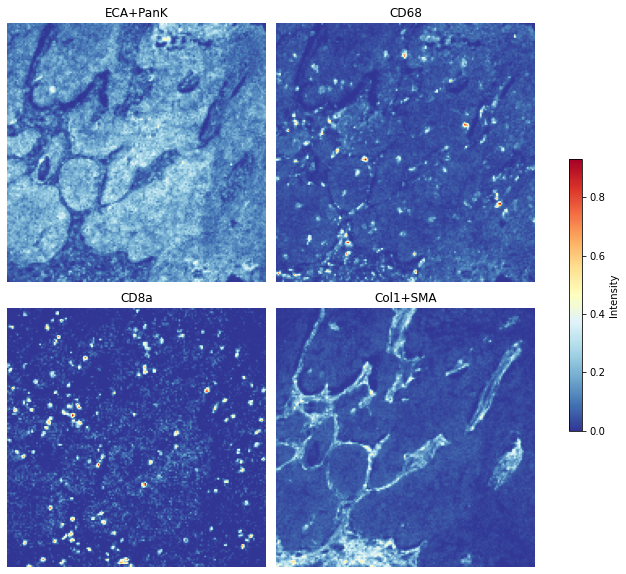

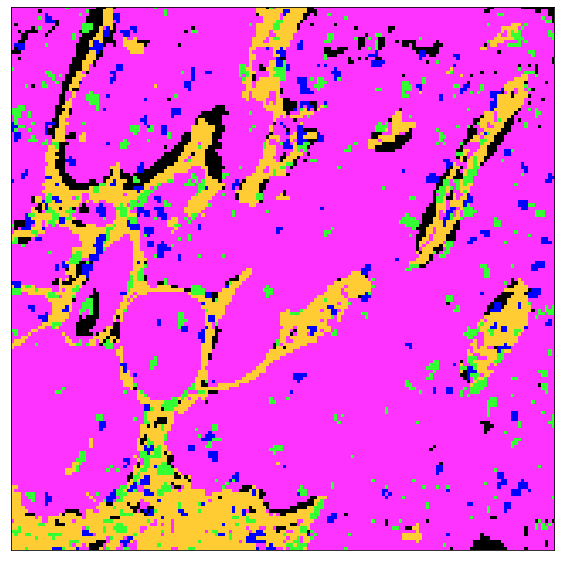

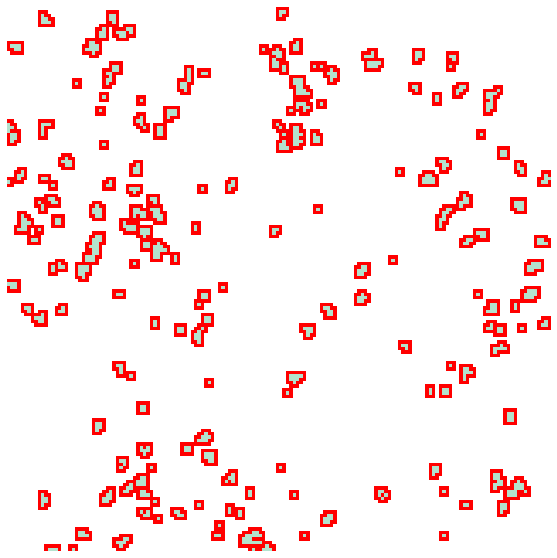

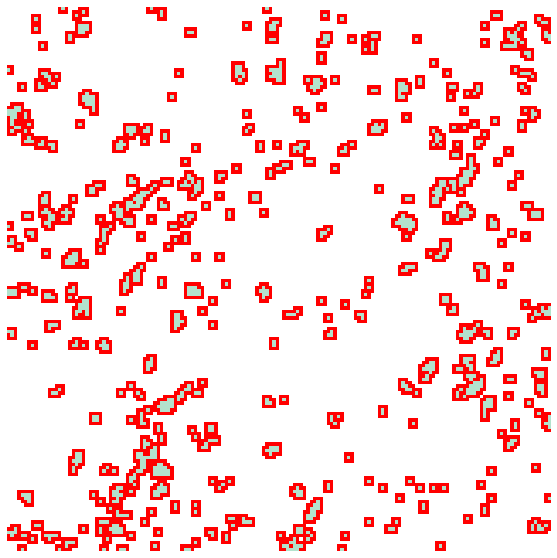

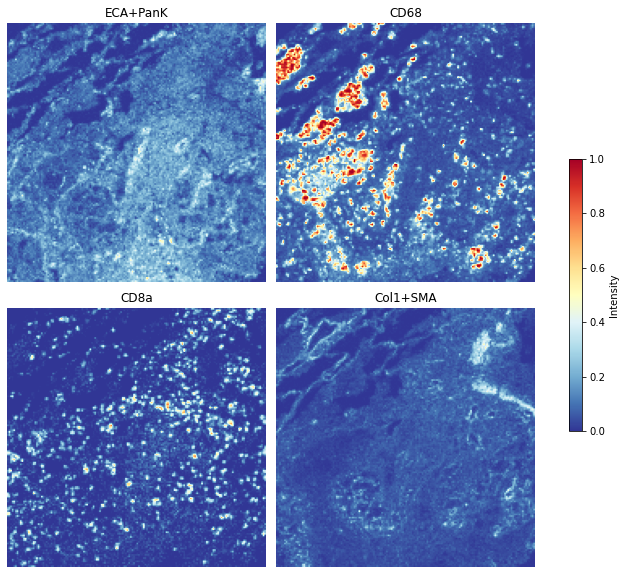

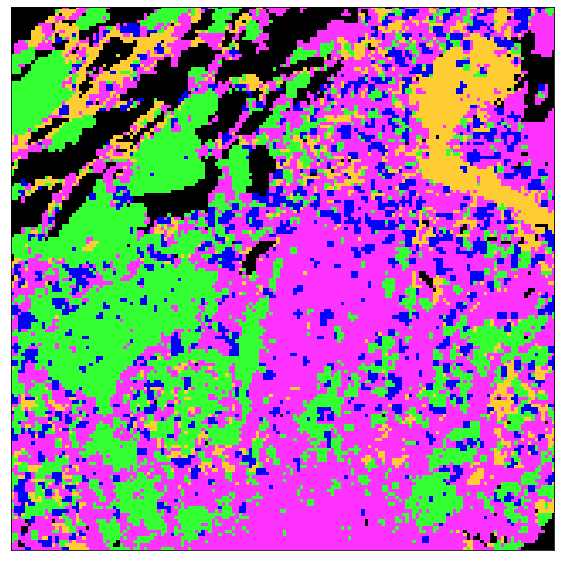

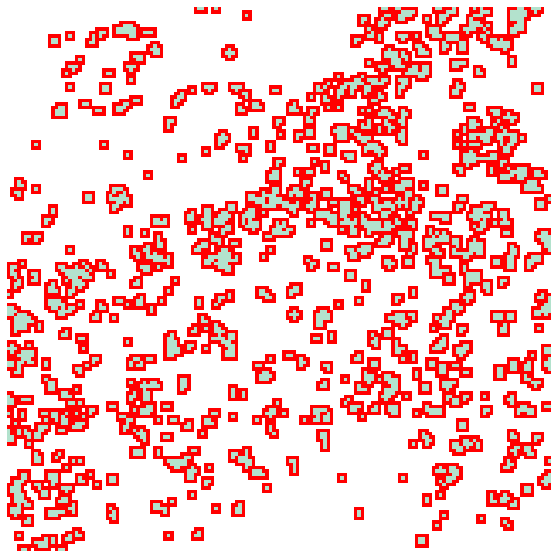

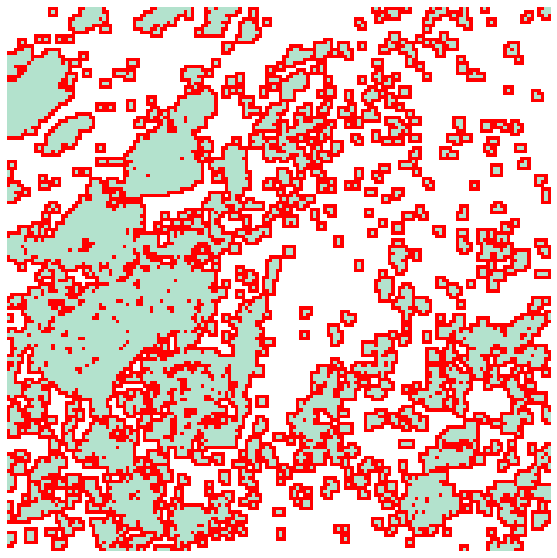

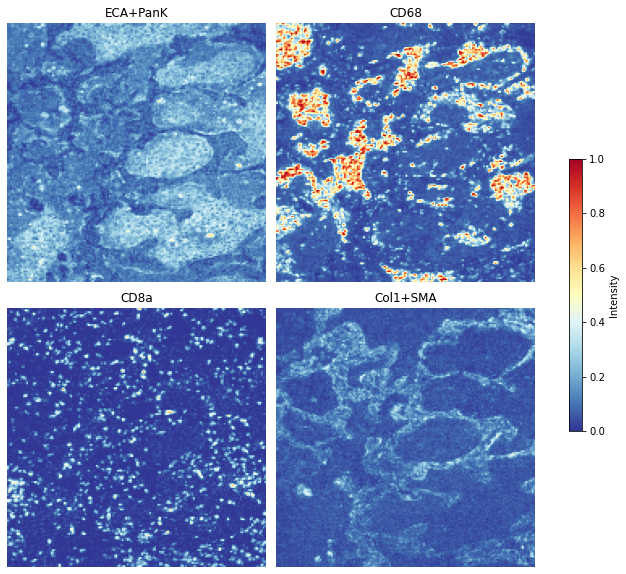

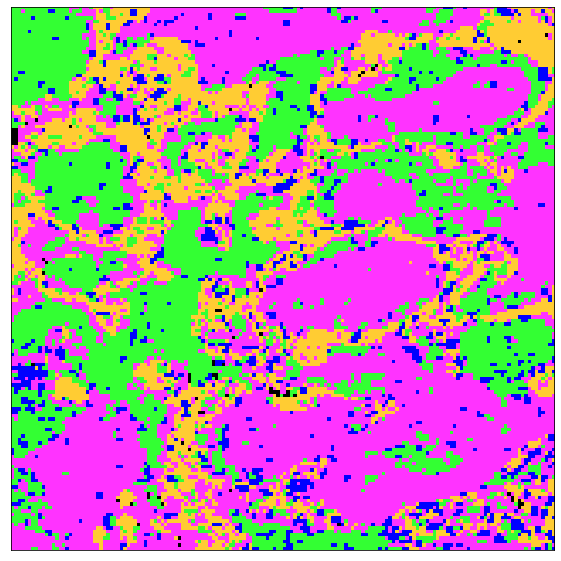

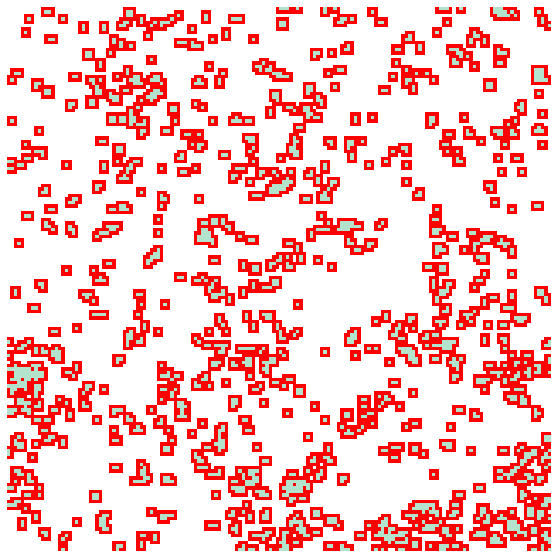

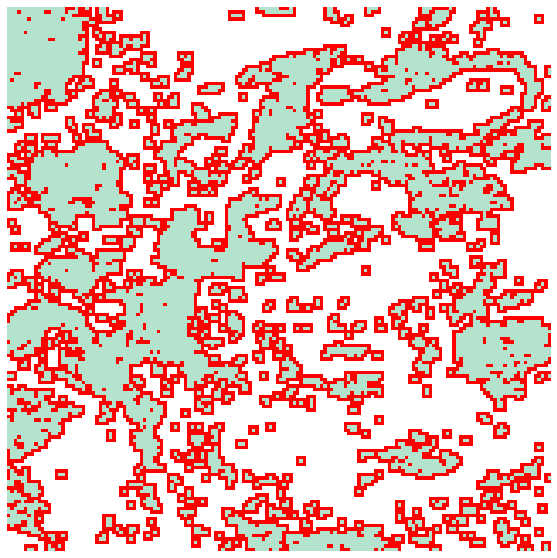

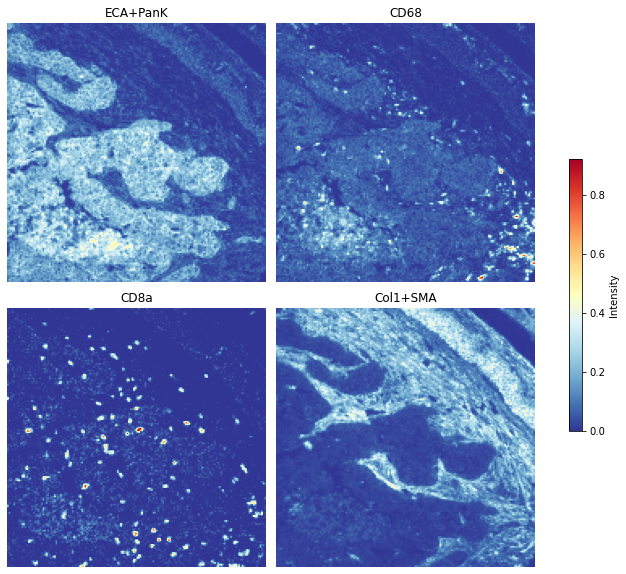

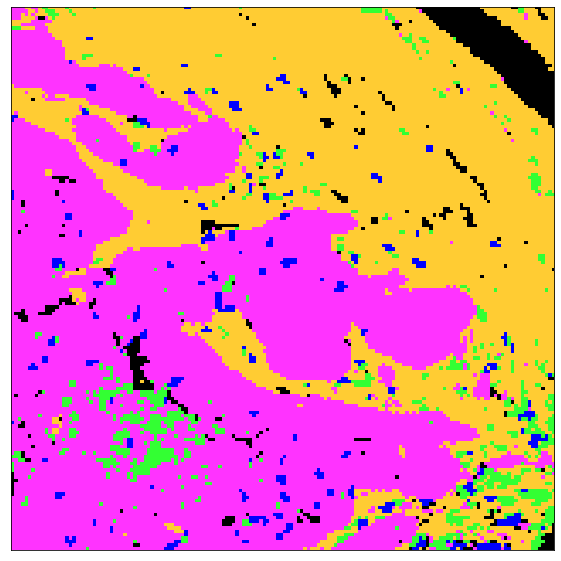

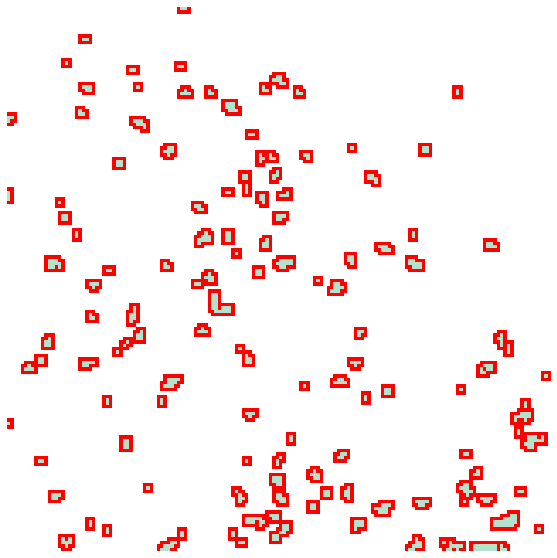

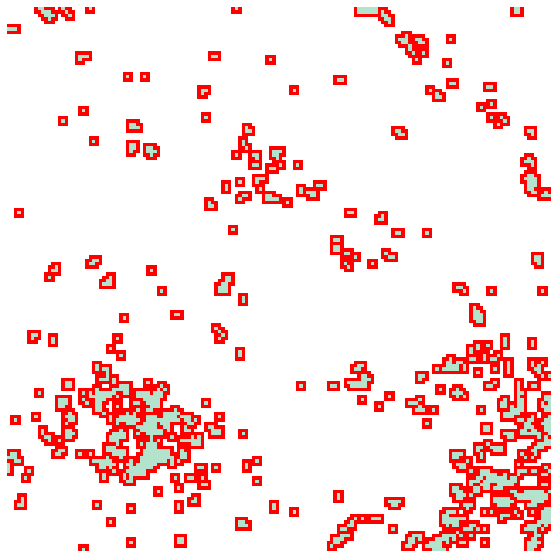

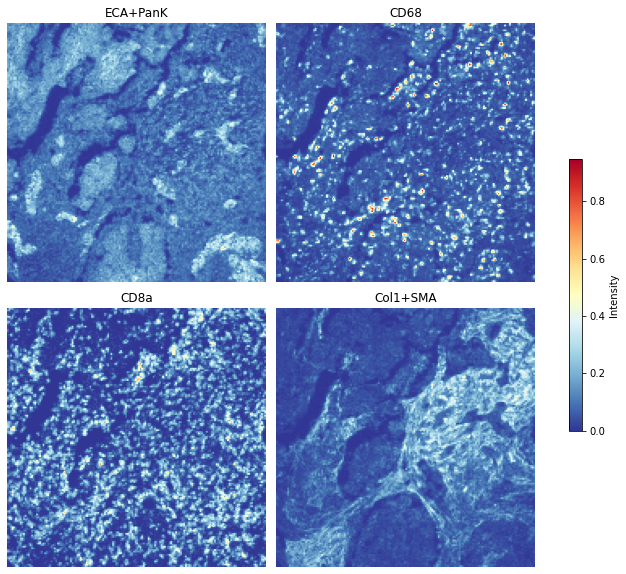

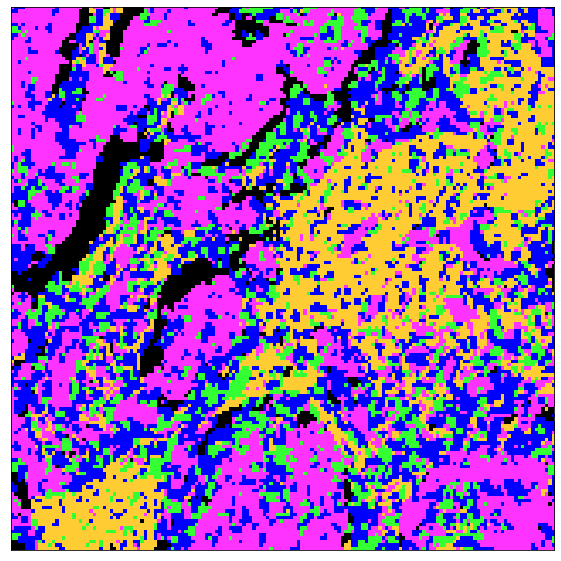

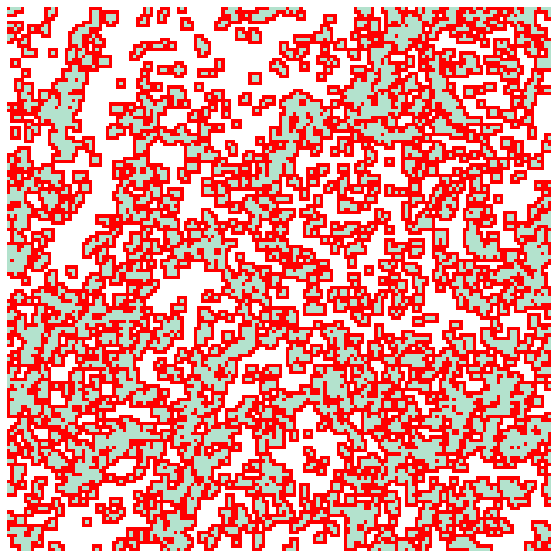

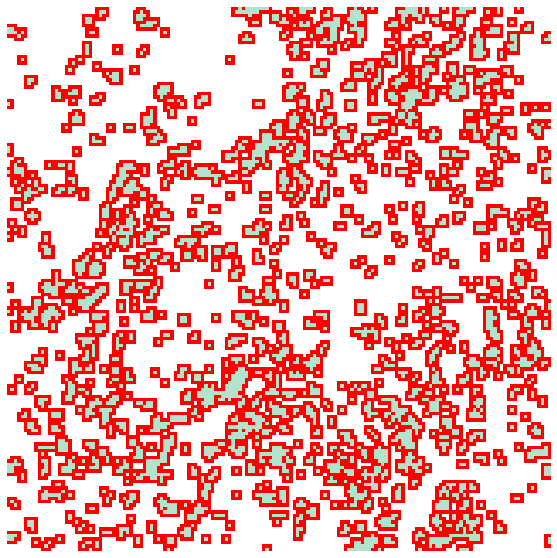

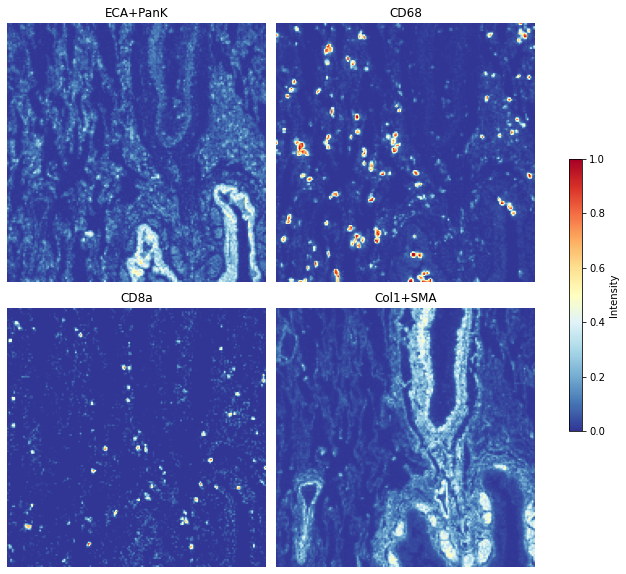

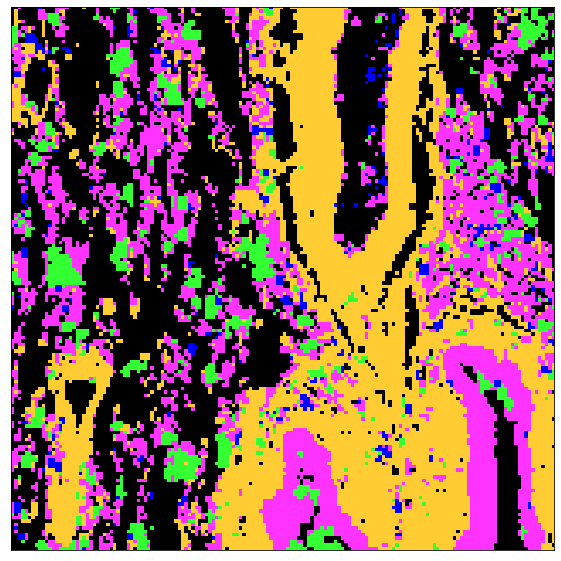

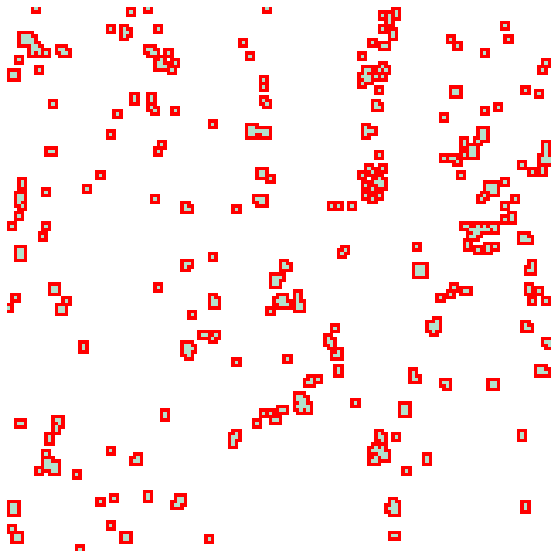

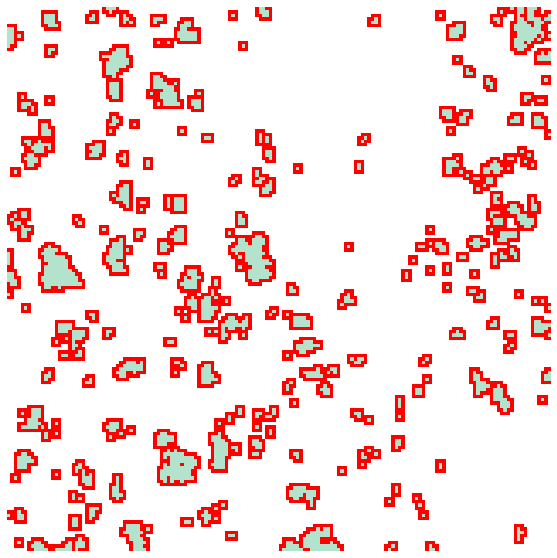

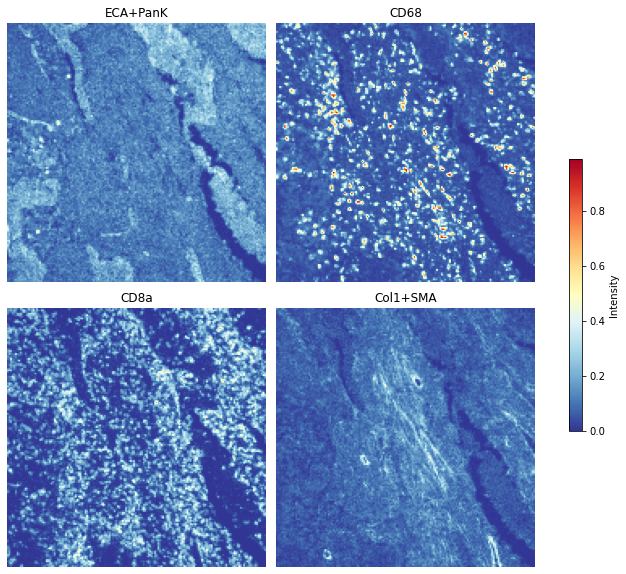

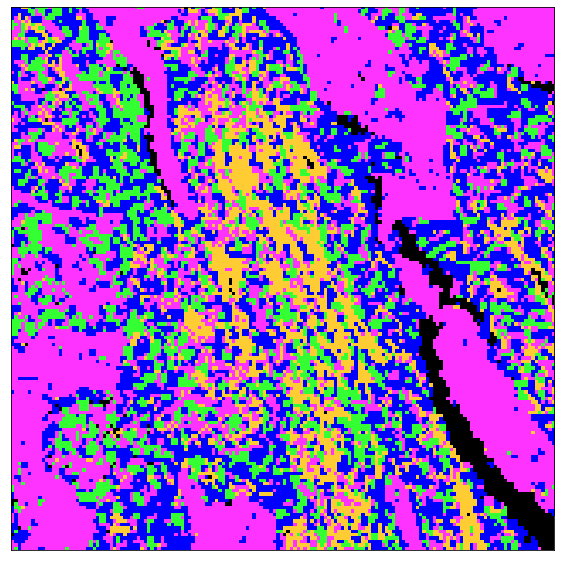

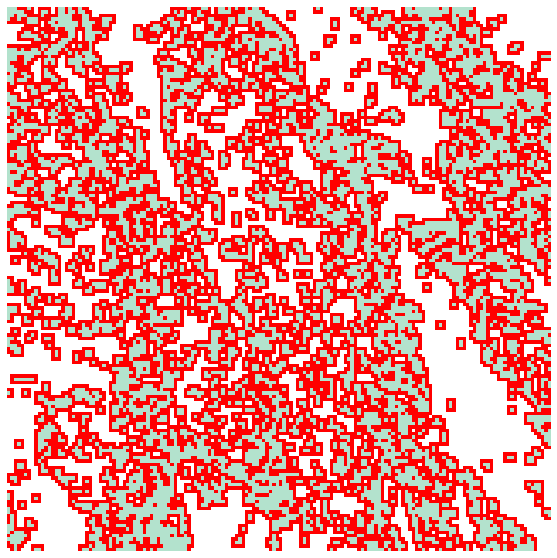

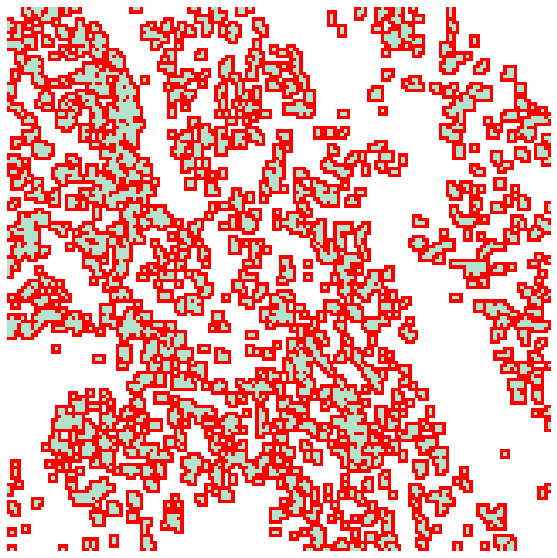

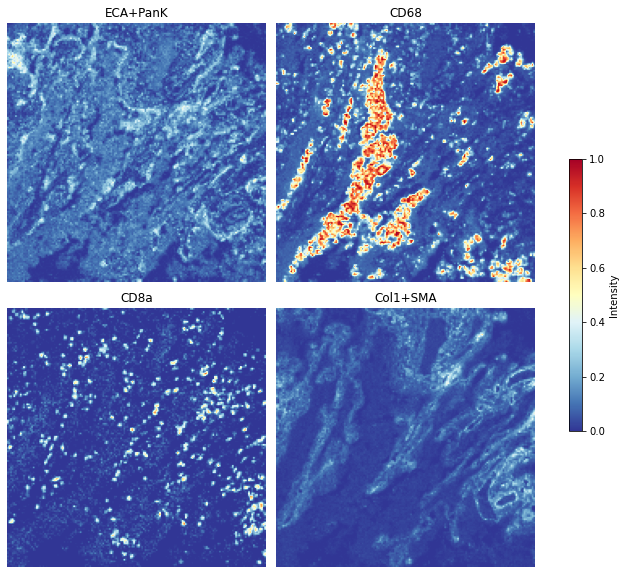

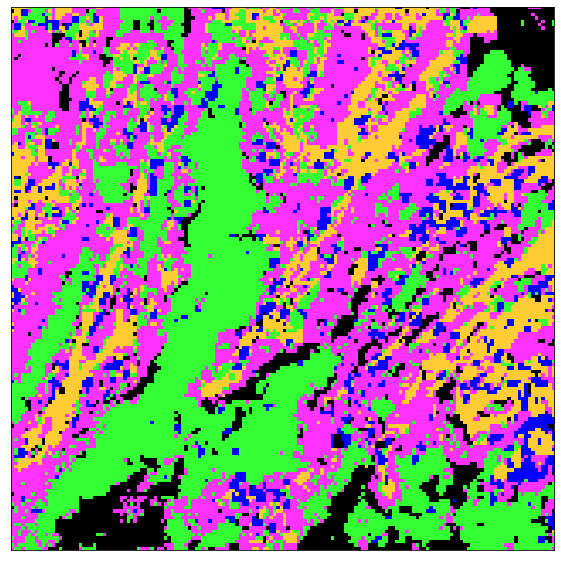

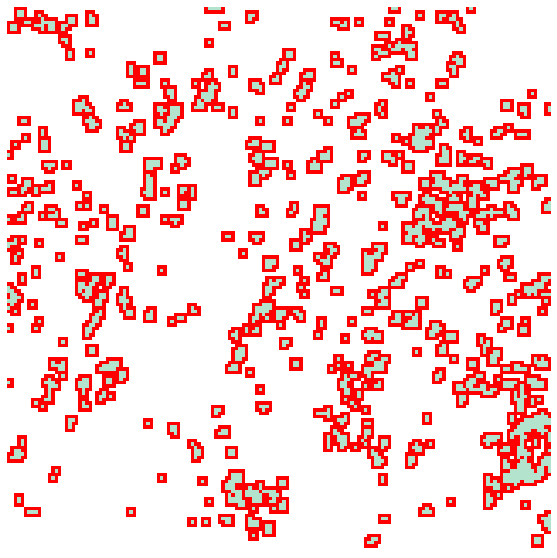

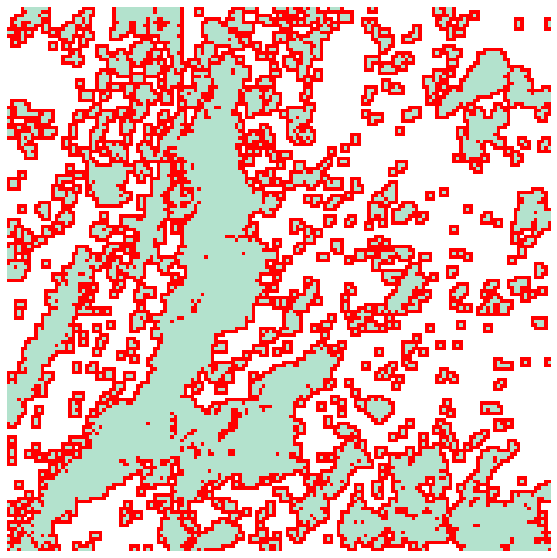

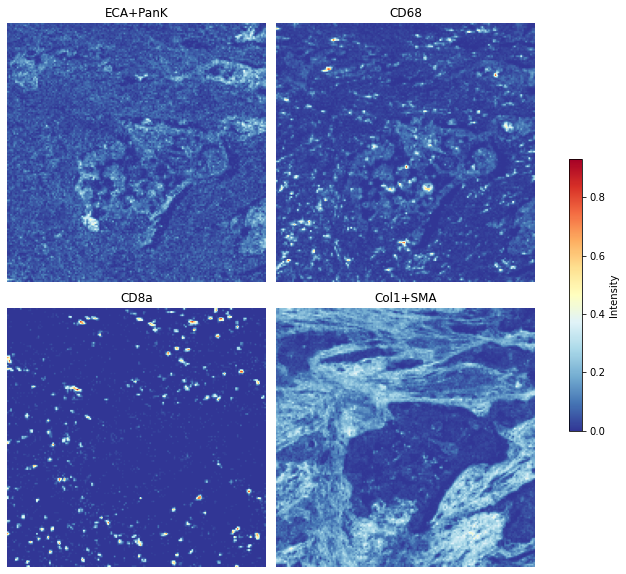

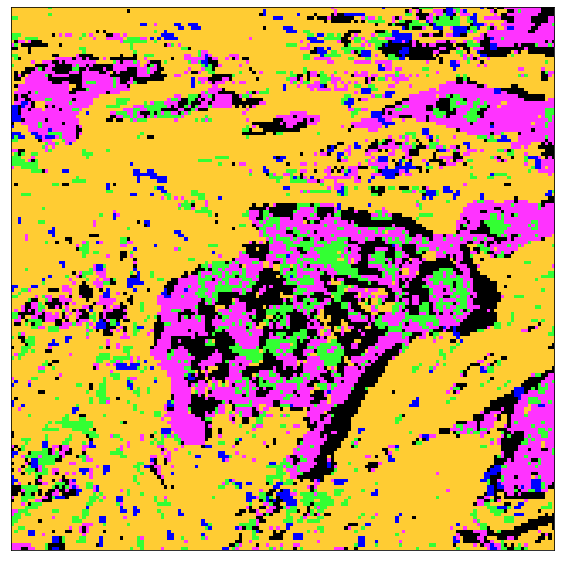

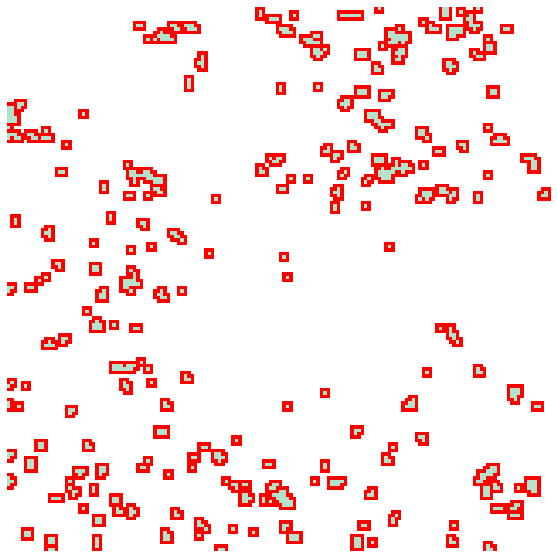

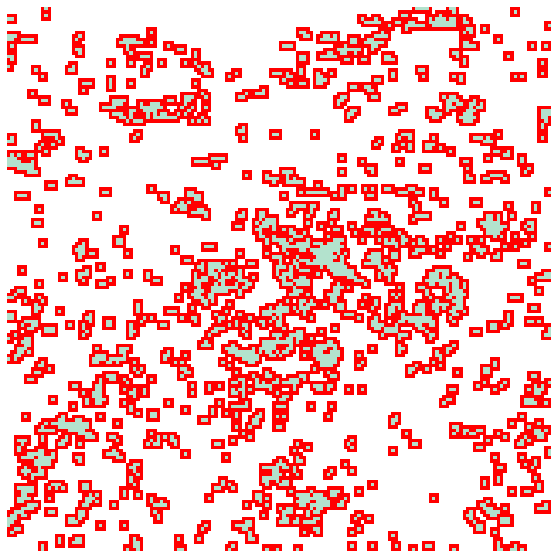

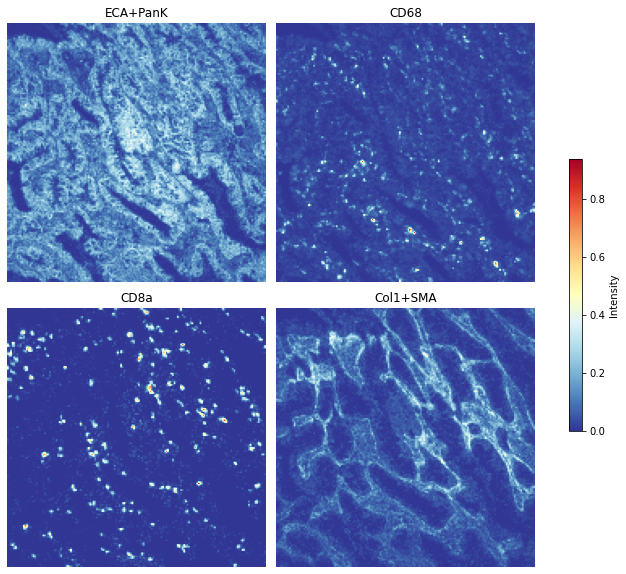

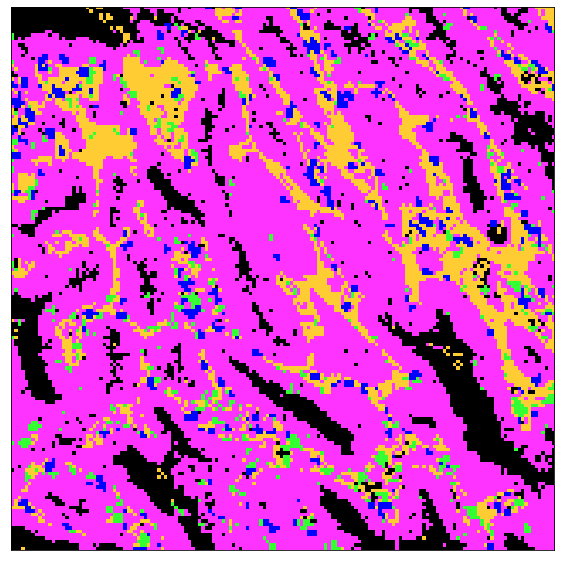

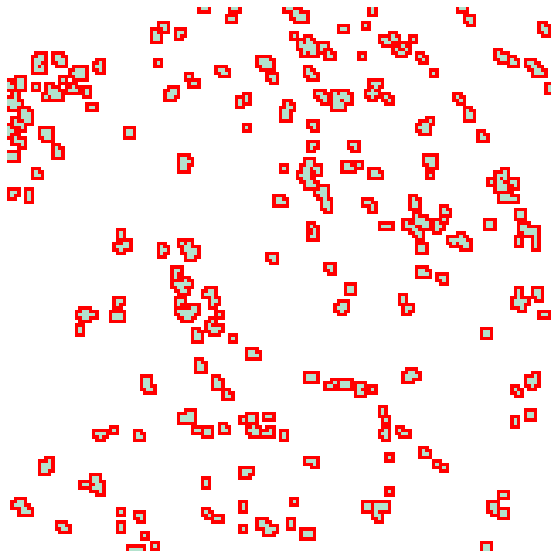

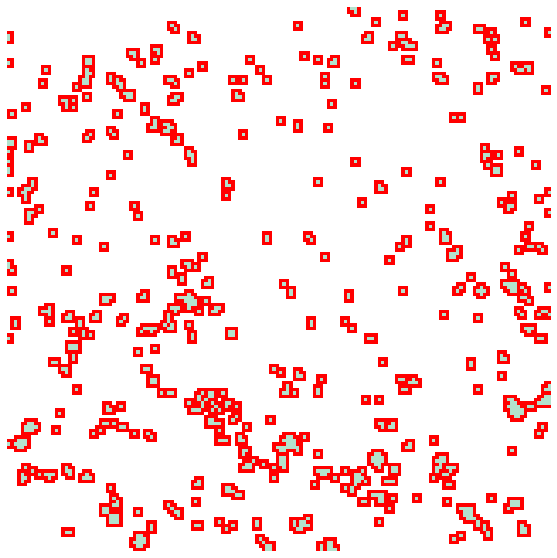

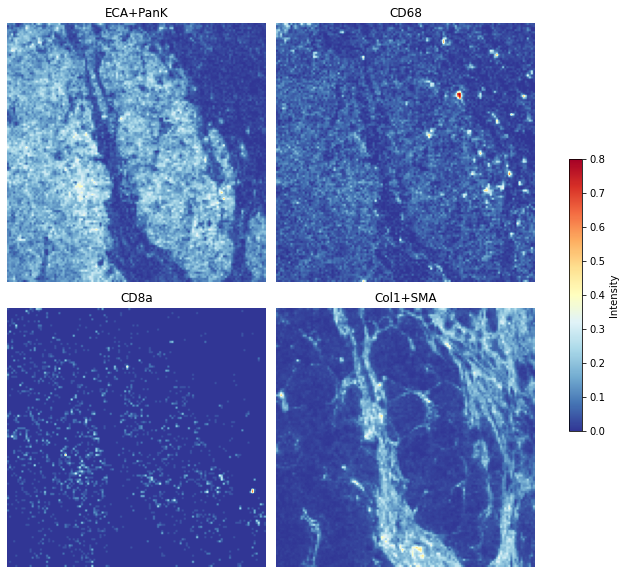

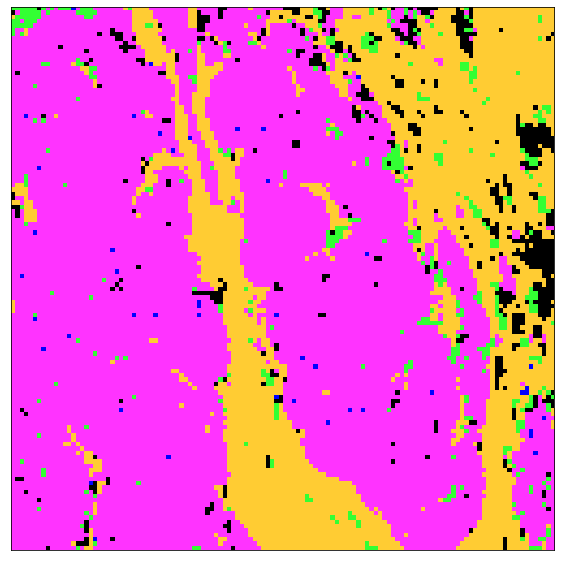

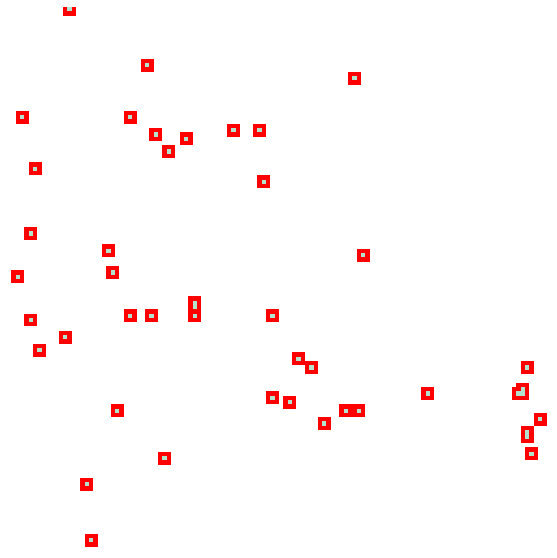

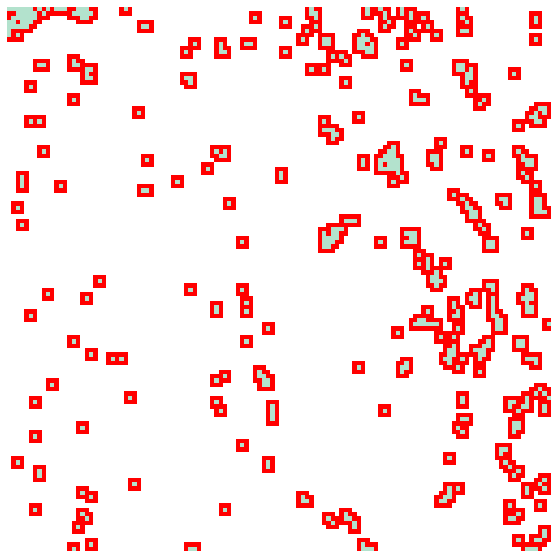

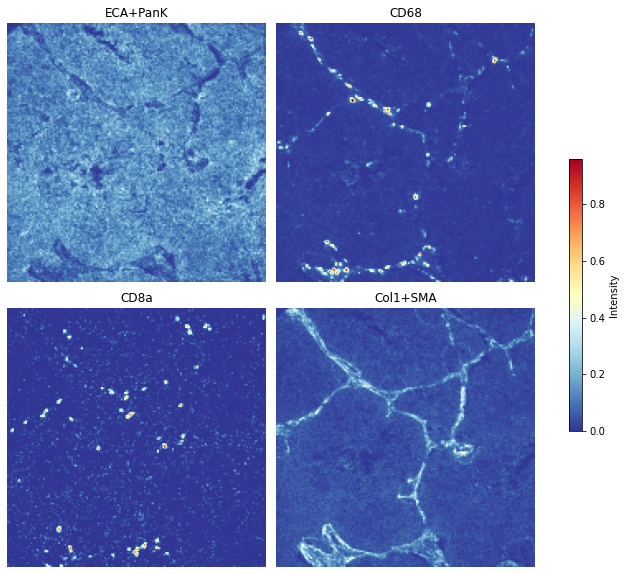

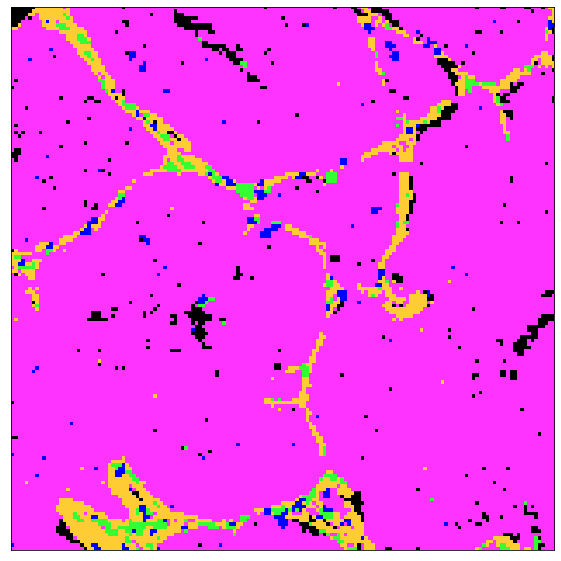

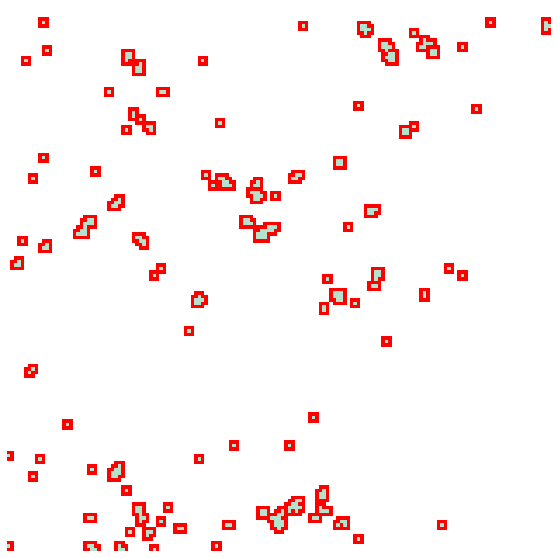

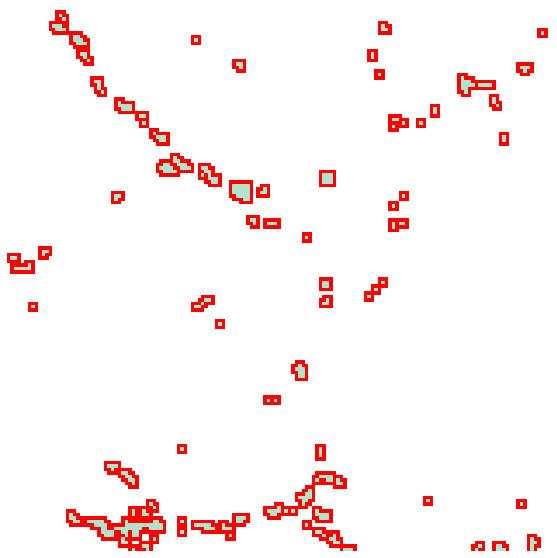

In [14]:
from skimage.restoration import denoise_bilateral

n = 5
scores = defaultdict(list)

for dataset in datasets:

    # Read image and cell_mask
    imgs, markers = io.read_img(dataset, data_ROI)
    marker2img = dict(zip(markers, imgs))
    min_shape = min(imgs[0].shape[0], imgs[0].shape[1])
    min_shape = myround(min_shape, base=n)
#     p2, p98 = np.percentile(imgs, (20.0, 99.0))
    imgs_list = []
    for markers in marker_list:
        temp = []
        for marker in markers:
            img = marker2img[marker]
            if marker == 'CD8a':
                img = median(img, disk(1))
            p2, p98 = np.percentile(img, (0, 99.9))
            img = exposure.rescale_intensity(img, in_range=(p2, p98))
            temp.append(img[:min_shape, :min_shape])
        imgs_list.append(np.array(np.mean(temp, axis=(0))))

    # Grayscale backgroun image
    data = np.stack(imgs_list, axis=2)[:min_shape, :min_shape]
    
    # Pixel
    patch_matrix = plot_mean(imgs_list, n, data_figure / 'border_pixel' / f'region_{dataset}.png', labels)
    patch_max = plot_combined(imgs_list, n, data_figure / 'border_pixel' / f'combined_{dataset}.png')
    
    scores['Tumor'].append(get_proportion(patch_max, 0))
    IN_prop = get_proportion(patch_max, 1)
    scores['CD68+'].append(IN_prop)
    IP_prop = get_proportion(patch_max, 2)
    scores['CD8+'].append(IP_prop)
    scores['Stroma'].append(get_proportion(patch_max, 3))
    
    IN_labels = get_label_img(patch_max, 1)
    IP_labels = get_label_img(patch_max, 2)
    
    # Immune positif
    _, contours = get_contour(IP_labels, n=2)
    counts = get_contour_env(IP_labels, contours, patch_max)
    tumor_int, stroma_int, ip_int, in_int = get_interaction(counts)
    
    scores['CD8-T'].append(tumor_int*IP_prop)
    scores['CD8-S'].append(stroma_int*IP_prop)
    scores['CD8-CD68'].append(in_int*IP_prop)
    
    # Immune negatif
    _, contours = get_contour(IN_labels, n=2)
    counts = get_contour_env(IN_labels, contours, patch_max)
    tumor_int, stroma_int, ip_int, in_int = get_interaction(counts)

    scores['CD68-T'].append(tumor_int*IN_prop)
    scores['CD68-S'].append(stroma_int*IN_prop)
    scores['CD68-CD8'].append(ip_int*IN_prop)

In [15]:
df = pd.DataFrame(scores, index=datasets)
df.index = [index[-2:] for index in df.index]

df

Tumor     CD68+      CD8+    Stroma     CD8-T     CD8-S  CD8-CD68  \
B1  0.835156  0.019141  0.002969  0.099961  0.002320  0.000566  0.000060   
B3  0.409883  0.089023  0.027734  0.352500  0.013067  0.010379  0.003653   
B5  0.743867  0.044336  0.030820  0.134687  0.018996  0.008339  0.002006   
C6  0.416914  0.280117  0.098281  0.103867  0.053060  0.011627  0.030139   
D7  0.453906  0.282500  0.072656  0.188047  0.032163  0.014918  0.025487   
D9  0.466875  0.046602  0.023281  0.423594  0.011294  0.008857  0.002425   
E1  0.323984  0.129062  0.272422  0.203359  0.115107  0.090856  0.048125   
B6  0.226328  0.066172  0.020742  0.306406  0.007242  0.004270  0.001502   
F3  0.377617  0.162188  0.290469  0.134414  0.134412  0.071461  0.077017   
F2  0.358125  0.308008  0.073867  0.157109  0.034036  0.018851  0.017755   
G1  0.182578  0.094570  0.029297  0.562539  0.004502  0.018917  0.002805   
G5  0.640078  0.032461  0.036016  0.146484  0.021853  0.011067  0.002385   
E5  0.641093  0.032061  0.002897  0.280801  0.002488  0.000308  0.000051   
E7  0.882632  0.015011  0.011359  0.062883  0.007324  0.002730  0.000975   

      CD68-T    CD68-S  CD68-CD8  
B1  0.012284  0.006317  0.000120  
B3  0.039331  0.041931  0.003752  
B5  0.029305  0.010918  0.001983  
C6  0.170379  0.042958  0.044254  
D7  0.133786  0.111705  0.034941  
D9  0.017905  0.024704  0.002327  
E1  0.037625  0.036480  0.047942  
B6  0.023946  0.018690  0.002718  
F3  0.056179  0.032599  0.071093  
F2  0.174038  0.071292  0.033594  
G1  0.028900  0.048903  0.003096  
G5  0.019430  0.009355  0.001916  
E5  0.016345  0.012178  0.000089  
E7  0.006261  0.006899  0.001102

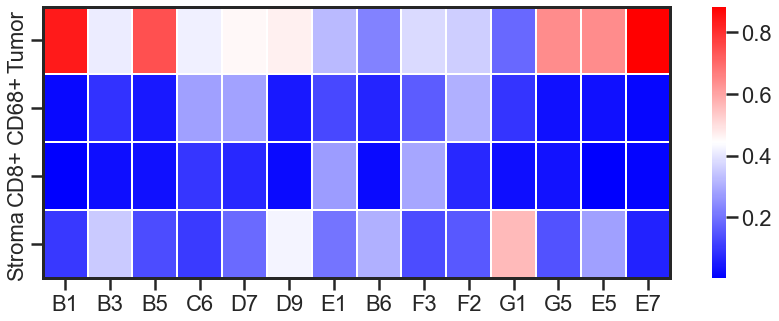

In [16]:
# Clustermap
from matplotlib.colors import LogNorm

my_cmap = 'bwr'
scale_name = "Score"

sns.set_style("ticks")
sns.set_context("poster")

fig, ax = plt.subplots(figsize=(15,5))
ax = sns.heatmap(
    df.iloc[:,:4].T,
    cbar_kws={"fraction": 0.2},
    cmap=my_cmap,
    linewidth=0.1,
#     norm = LogNorm()
)

ax.set_yticklabels(ax.get_yticklabels(), va='center')

for _, spine in ax.spines.items():
    spine.set_visible(True)
    spine.set_linewidth(3)

C:\Users\thu71\Anaconda3\envs\new_codex\lib\site-packages\seaborn\categorical.py:1296: UserWarning: 7.1% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


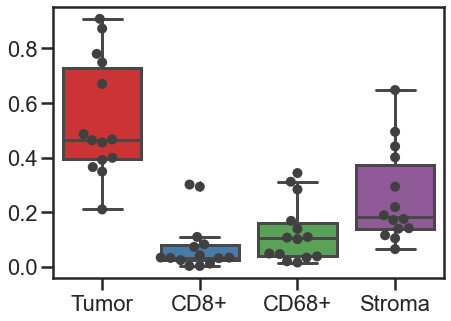

In [19]:
sns.set_style("ticks")
sns.set_context("poster")

df_subset = df.iloc[:,[0,2,1,3]]
df_subset = df_subset.div(df_subset.sum(axis=1), axis=0)

fig, ax = plt.subplots(figsize=(7, 5))
ax = sns.boxplot(data=df_subset, palette="Set1", order=['Tumor',  'CD8+', 'CD68+', 'Stroma'])
ax = sns.swarmplot(data=df_subset, color="0.25", size=10, order=['Tumor',  'CD8+', 'CD68+', 'Stroma'])

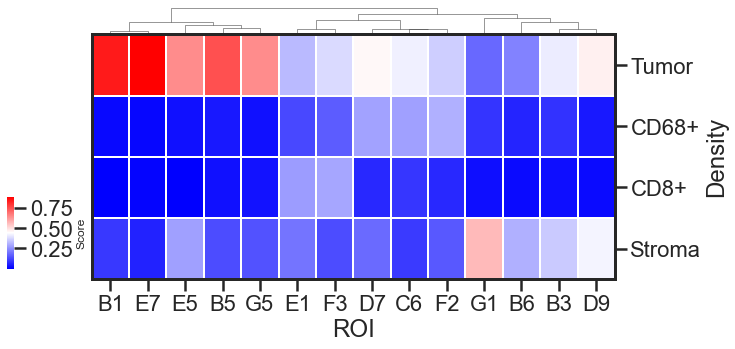

In [20]:
my_cmap = 'bwr'
scale_name = "Score"

# Clustermap
ax = sns.clustermap(
    df.iloc[:,:4].T,
    cbar_kws={"fraction": 0.01},
    cmap=my_cmap,
    row_cluster=False,
    dendrogram_ratio=(0.1, 0.1),
    linewidth=0.1,
    cbar_pos=(0, 0.2, 0.01, 0.2),
    figsize=(10,5),
)
ax.ax_heatmap.set_ylabel("Density")
ax.ax_heatmap.set_xlabel("ROI")

# Change colorbar label position
cbar = ax.ax_heatmap.collections[0].colorbar
cbar.set_label(scale_name, fontsize=12)

for _, spine in ax.ax_heatmap.spines.items():
    spine.set_visible(True)
    spine.set_linewidth(3)

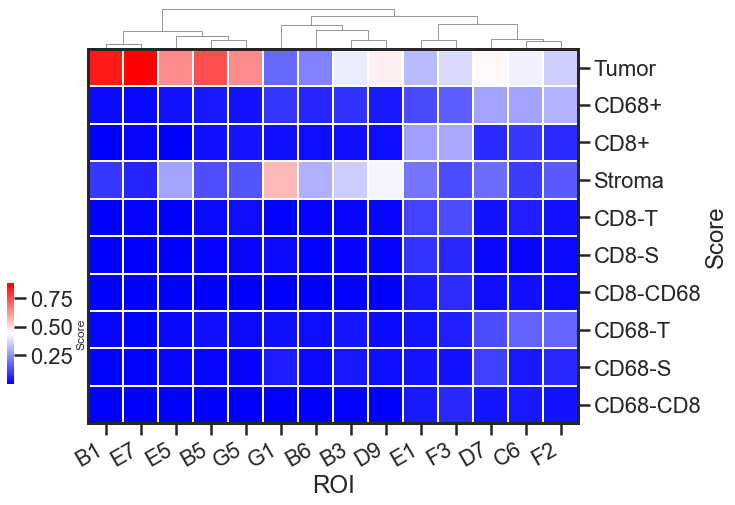

In [21]:
my_cmap = 'bwr'
scale_name = "Score"

# Clustermap
ax = sns.clustermap(
    df.T,
    cbar_kws={"fraction": 0.01},
    cmap=my_cmap,
    row_cluster=False,
    dendrogram_ratio=(0.1, 0.1),
    linewidth=0.1,
    cbar_pos=(0, 0.2, 0.01, 0.2),
    figsize=(10,7),
)
ax.ax_heatmap.set_xticklabels(
    ax.ax_heatmap.get_xticklabels(), rotation=30, horizontalalignment="right"
)
ax.ax_heatmap.set_ylabel("Score")
ax.ax_heatmap.set_xlabel("ROI")

# Change colorbar label position
cbar = ax.ax_heatmap.collections[0].colorbar
cbar.set_label(scale_name, fontsize=12)

for _, spine in ax.ax_heatmap.spines.items():
    spine.set_visible(True)
    spine.set_linewidth(3)

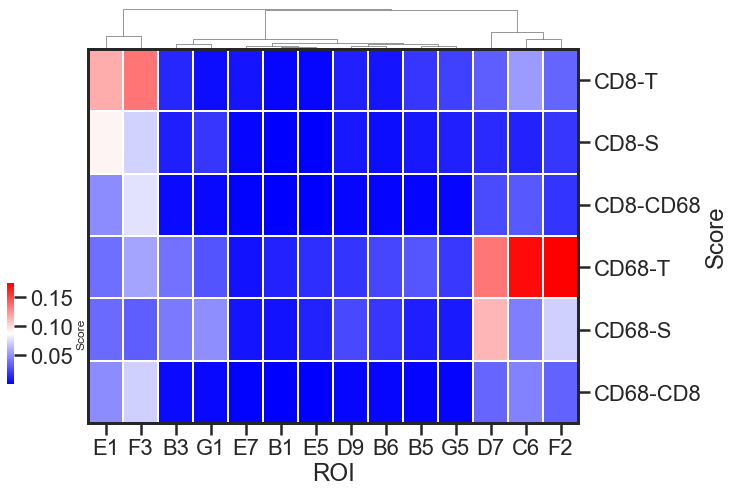

In [22]:
# Clustermap
ax = sns.clustermap(
    df.iloc[:,4:].T,
    cbar_kws={"fraction": 0.01},
    cmap='bwr',
    row_cluster=False,
    dendrogram_ratio=(0.1, 0.1),
    linewidth=0.1,
    cbar_pos=(0, 0.2, 0.01, 0.2),
    figsize=(10,7),
)
ax.ax_heatmap.set_ylabel("Score")
ax.ax_heatmap.set_xlabel("ROI")

# Change colorbar label position
cbar = ax.ax_heatmap.collections[0].colorbar
cbar.set_label(scale_name, fontsize=12)

for _, spine in ax.ax_heatmap.spines.items():
    spine.set_visible(True)
    spine.set_linewidth(3)

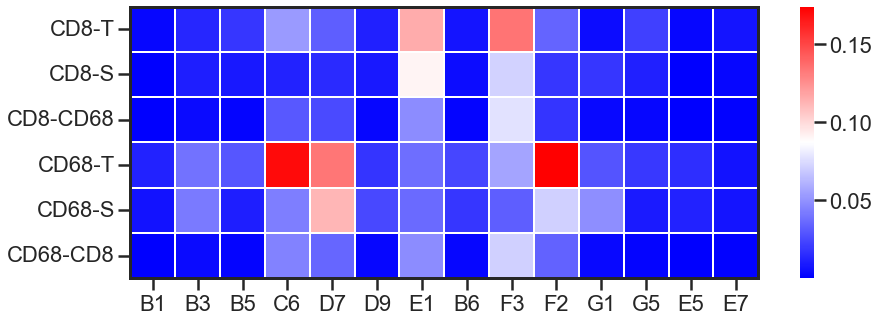

In [23]:
# Clustermap
from matplotlib.colors import LogNorm

my_cmap = 'bwr'
scale_name = "Score"

sns.set_style("ticks")
sns.set_context("poster")

fig, ax = plt.subplots(figsize=(15,5))
ax = sns.heatmap(
    df.iloc[:,4:].T,
    cbar_kws={"fraction": 0.2},
    cmap=my_cmap,
    linewidth=0.1,
#     norm = LogNorm()
)

ax.set_yticklabels(ax.get_yticklabels(), va='center')

for _, spine in ax.spines.items():
    spine.set_visible(True)
    spine.set_linewidth(3)

In [ ]:
# proportions = defaultdict(list)

# proportions['tumor'] = get_proportion(patch_max, 0)
# proportions['IN'] = get_proportion(patch_max, 1)
# proportions['IP'] = get_proportion(patch_max, 2)
# proportions['stroma'] = get_proportion(patch_max, 3)

# IN_labels = get_label_img(patch_max, 1)
# IP_labels = get_label_img(patch_max, 2)

# counts, areas, labels, bboxs = get_neighbor_env(IN_labels, patch_max)
# tumor_int, stroma_int, ip_int, in_int = get_interaction(counts)
# print(tumor_int, stroma_int, ip_int, in_int)

# counts, areas, labels, bboxs = get_neighbor_env(IP_labels, patch_max)
# tumor_int, stroma_int, ip_int, in_int = get_interaction(counts)
# print(tumor_int, stroma_int, ip_int, in_int)

# print(proportions)


In [22]:
# labels, contours = get_contour(IN_labels, n=2)
# counts = get_contour_env(IN_labels, contours, patch_max)
  
# tumor_int, stroma_int, ip_int, in_int = get_interaction(counts)
# print(tumor_int, stroma_int, ip_int, in_int)

# labels, contours = get_contour(IP_labels, n=2)
# counts = get_contour_env(IP_labels, contours, patch_max)
  
# tumor_int, stroma_int, ip_int, in_int = get_interaction(counts)
# print(tumor_int, stroma_int, ip_int, in_int)